In [1]:
%env TOKENIZERS_PARALLELISM=false
import json
import logging
import math
import os
import random
import matplotlib.pyplot as plt 
import sys
from dataclasses import dataclass, field
from itertools import chain
from pathlib import Path
from typing import Optional
import numpy as np 
import pandas as pd 
import datasets
import tensorflow as tf
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import transformers
from transformers import AutoTokenizer , TFAutoModelForMaskedLM
from transformers.utils import send_example_telemetry
from transformers.utils.versions import require_version
from tqdm.notebook import tqdm
from datasets import Dataset
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
import tensorflow_addons as tfa
from sklearn.metrics import f1_score
from ast import literal_eval
import warnings 
from tensorflow.keras.layers import GlobalMaxPooling1D
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')
pd.set_option("display.max_info_columns", 200)
from transformers.optimization_tf import AdamWeightDecay

env: TOKENIZERS_PARALLELISM=false


In [2]:
# loading the pretrained model 
pretrained_model = TFAutoModelForMaskedLM.from_pretrained('/kaggle/input/project-mlm-nbme/nbme_mlm_model')


All model checkpoint layers were used when initializing TFDebertaV2ForMaskedLM.

All the layers of TFDebertaV2ForMaskedLM were initialized from the model checkpoint at /kaggle/input/project-mlm-nbme/nbme_mlm_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2ForMaskedLM for predictions without further training.


In [3]:
features_df = pd.read_csv("/kaggle/input/bighandsome/NBME/features.csv")
patient_notes_df = pd.read_csv("/kaggle/input/bighandsome/NBME/patient_notes.csv")
train_df = pd.read_csv("/kaggle/input/bighandsome/NBME/train.csv")

In [4]:
@dataclass
class config:
    model:str=field(default="microsoft/deberta-v3-base")
    train_batch_size:int = field(default=8)
    test_batch_size:int = field(default=16)
    max_lenght:int = field(default=None)
    learning_rate:float = field(default=5e-4)
    epochs:int = field(default=5)


In [5]:
tokenizer = AutoTokenizer.from_pretrained(config.model)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
df = pd.merge(train_df, features_df, on=['feature_num','case_num'], how='inner')
df =pd.merge(df, patient_notes_df, on=['pn_num','case_num'], how='inner')
df.head()

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...
2,00016_002,0,16,2,['chest pressure'],['203 217'],Chest-pressure,HPI: 17yo M presents with palpitations. Patien...
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],Lightheaded,HPI: 17yo M presents with palpitations. Patien...


In [7]:
pn_history_lengths = []
tk0 = tqdm(df['pn_history'].fillna("").values, total=len(df))
for text in tk0:
    length = tokenizer.encode(text,add_special_tokens=False)
        
    pn_history_lengths.append(len(length))
print(f'pn_history max(lengths): {max(pn_history_lengths)}')


features_lengths=[]
tk1 = tqdm(df['feature_text'].fillna("").values, total=len(df))
for text in tk1:
    length = tokenizer.encode(text,add_special_tokens=False)
    features_lengths.append(len(length))
print(f'feature_text  max(lengths): {max(features_lengths)}')

max_lenght= max(pn_history_lengths) + max(features_lengths) + 3 # cls & sep & sep
print(f"max_len: {max_lenght}")

config.max_lenght=max_lenght

  0%|          | 0/14300 [00:00<?, ?it/s]

pn_history max(lengths): 309


  0%|          | 0/14300 [00:00<?, ?it/s]

feature_text  max(lengths): 28
max_len: 340


In [8]:
# always use literal_eval instead of eval https://nedbatchelder.com/blog/201206/eval_really_is_dangerous.html
df["annotation"] = [literal_eval(x) for x in df["annotation"]] 
df["location"] = [literal_eval(x) for x in df["location"]]

In [9]:
def loc_list_to_ints(loc_list):
    to_return = []
    for loc_str in loc_list:  
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            to_return.append((int(start), int(end)))
    return to_return

In [10]:
def classLabeling(pn_history, feature_text, annotation, location, tokenizer, max_len):    ##X , Y, selected_text  
    

    location_list = loc_list_to_ints(location)   # convert the locations into a list 


    char_targets = [0] * len(pn_history)  # creation of character taragert you can reason below 

    for loc,anno in zip(location_list ,annotation):        
        
        len_st = int(loc[1]) - int(loc[0])
        idx0 = None
        idx1 = None        
        for ind in (i for i, e in enumerate(pn_history) if (e == anno[0] and i == int(loc[0]))): # Only if the annotation start with character we are interested and look and character annotation postion match go inside the loop
        
            if pn_history[ind: ind+len_st] == anno.strip():

                idx0 = ind
                idx1 = ind + len_st - 1
                if idx0 != None and idx1 != None:
                    for ct in range(idx0, idx1 + 1): # make character targets as "1" for them 
                        char_targets[ct] = 1 
                break
    # Tokenize the data and here we are returing the offstes which we gone use as labels which you can find below 
    tokenized_input = tokenizer.encode_plus(feature_text,pn_history,return_attention_mask=True,
                                                  return_offsets_mapping=True,return_token_type_ids=True)
    
    input_ids = tokenized_input['input_ids']
    mask = tokenized_input['attention_mask']
    token_type_ids = tokenized_input['token_type_ids']
    offsets = tokenized_input['offset_mapping']
    
    target_idx = []
    for j, (offset1, offset2) in enumerate(offsets): # look for offsets 
        if sum(char_targets[offset1: offset2]) > 0: # if the lenght of the char_target for particualr target is greater than 0 then added one at that offsets 
            target_idx.append(j)
            
    #padding
    padding_length = max_len- len(input_ids) # Since we used 312 as max_lenght incase if we less lenght we need to pad the zeros 
    if padding_length > 0:
        input_ids = input_ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        offsets = offsets + ([(0, 0)] * padding_length)
       
    #creating label
    ignore_idxes = np.where(np.array(token_type_ids) != 1)[0] # Bascially we use token type ids Segment token indices to indicate first and second portions of the input

    label = np.zeros(len(offsets))
    label[ignore_idxes] = 0.0 # creating a labels zero for not interested to look 
    label[target_idx] = 1.0  # label for which we are interested to look
    return {
    'ids': input_ids,
    'mask': mask,
    'token_type_ids': token_type_ids,
    'labels': label,
    'offsets': offsets
}

In [11]:
# define the function to create the dataset
def create_dataset(data):
    # create empty lists to store inputs and labels
    ids, masks, token_types, labels = [], [], [], []

    for index,row in data.iterrows():

        # extract the inputs and labels using classLabeling function
        inputs = classLabeling(row['pn_history'], row['feature_text'], 
                               row['annotation'], row['location'], 
                               tokenizer, config.max_lenght)

        # append the inputs and labels to the respective lists
        ids.append(inputs['ids'])
        masks.append(inputs['mask'])
        token_types.append(inputs['token_type_ids'])
        labels.append(inputs['labels'])

    # convert the lists to numpy arrays
    ids = np.array(ids)
    attention_masks = np.array(masks)
    token_type_ids = np.array(token_types)
    labels = np.array(labels)


    return {"input_ids":ids,"attention_mask": attention_masks,"token_type_ids":token_type_ids},labels

In [12]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
# Define function to calculate F1 score
def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)

In [13]:
# create df dataset
train_df = df.iloc[:int(0.8*len(df)),:]
val_df   = df.iloc[int(0.8*len(df)):,:]

In [14]:
train_data , train_labels =create_dataset(train_df)
val_data , val_labels = create_dataset(val_df)

In [15]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.f1 = tfa.metrics.F1Score(num_classes=2, average='micro', threshold=0.50)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, (-1,config.max_lenght))
        y_pred = tf.reshape(y_pred, (-1,config.max_lenght))
        self.f1.update_state(y_true, y_pred)
        
    def reset_state(self):
        self.f1.reset_state()
    
    def result(self):
        return self.f1.result()

In [16]:
def create_bert_model(hidden_size=100,learning_rate=config.learning_rate):
    
    input_ids = tf.keras.layers.Input(shape=(config.max_lenght,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(config.max_lenght,), dtype=tf.int32, name="attention_mask")
    token_type_ids = tf.keras.layers.Input(shape=(config.max_lenght,), dtype=tf.int32, name="token_type_ids")

    last_hidden_state = pretrained_model(input_ids= input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids, training=True)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(last_hidden_state.logits)
    
    model_history = tf.keras.Model(inputs=[input_ids,attention_mask,token_type_ids], outputs=[output])
    
    model_history.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[ F1Score()])
    
    return model_history

In [17]:
model_history = create_bert_model()

In [18]:
model_history.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 340)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 340)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 340)]        0           []                               
                                                                                                  
 tf_deberta_v2_for_masked_lm (T  TFMaskedLMOutput(lo  184551780  ['input_ids[0][0]',              
 FDebertaV2ForMaskedLM)         ss=None, logits=(No               'attention_mask[0][0]',     

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # look at val before we stop the training 
    min_delta=0.01,  #  if min_delta is set to 0.001 and the monitored quantity is validation loss, then if the validation loss decreases by less than 0.001 from the previous epoch, it will not be considered as an improvement, and the EarlyStopping callback will wait for more significant improvements before stopping the training.
    patience=5, # patience refers to the number of epochs the training process can continue without improvement in the monitored quantity (e.g., validation loss or accuracy) before the training process is stopped.
    verbose=1, # logging messages printed to the console at the end of each epoch
    mode='auto', # to decrese the loss 
    restore_best_weights=True # to save best weights
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', # look at val loss 
    factor=0.01,  # factor the learning rate to be decereased 
    patience=5,  # no.of epochs to be monitored 
    mode='auto', # to decrease loss 
    min_delta=0.001, # #  if min_delta is set to 0.001 and the monitored quantity is validation loss, then if the validation loss decreases by less than 0.001 from the previous epoch, it will not be considered as an improvement.
    verbose = 1
)

In [20]:
model_history_fine_tuned = model_history.fit(
    (train_data['input_ids'],train_data['attention_mask'],train_data['token_type_ids']),
    train_labels,
    validation_data=((val_data['input_ids'],val_data['attention_mask'],val_data['token_type_ids']), val_labels),
    batch_size=config.train_batch_size,
    epochs=config.epochs,
    callbacks = [early_stop, reduce_lr]
)  

Epoch 1/5
1430/1430 [==============================] - 1395s 940ms/step - loss: 0.1661 - f1: 0.0027 - val_loss: 0.0816 - val_f1: 0.0000e+00 - lr: 5.0000e-04
Epoch 2/5
1430/1430 [==============================] - 1336s 934ms/step - loss: 0.1138 - f1: 0.0000e+00 - val_loss: 0.0816 - val_f1: 0.0000e+00 - lr: 5.0000e-04
Epoch 3/5
1430/1430 [==============================] - 1329s 929ms/step - loss: 0.1138 - f1: 0.0000e+00 - val_loss: 0.0816 - val_f1: 0.0000e+00 - lr: 5.0000e-04
Epoch 4/5
1430/1430 [==============================] - 1336s 934ms/step - loss: 0.1138 - f1: 0.0000e+00 - val_loss: 0.0816 - val_f1: 0.0000e+00 - lr: 5.0000e-04
Epoch 5/5
1430/1430 [==============================] - 1336s 934ms/step - loss: 0.1138 - f1: 0.0000e+00 - val_loss: 0.0816 - val_f1: 0.0000e+00 - lr: 5.0000e-04


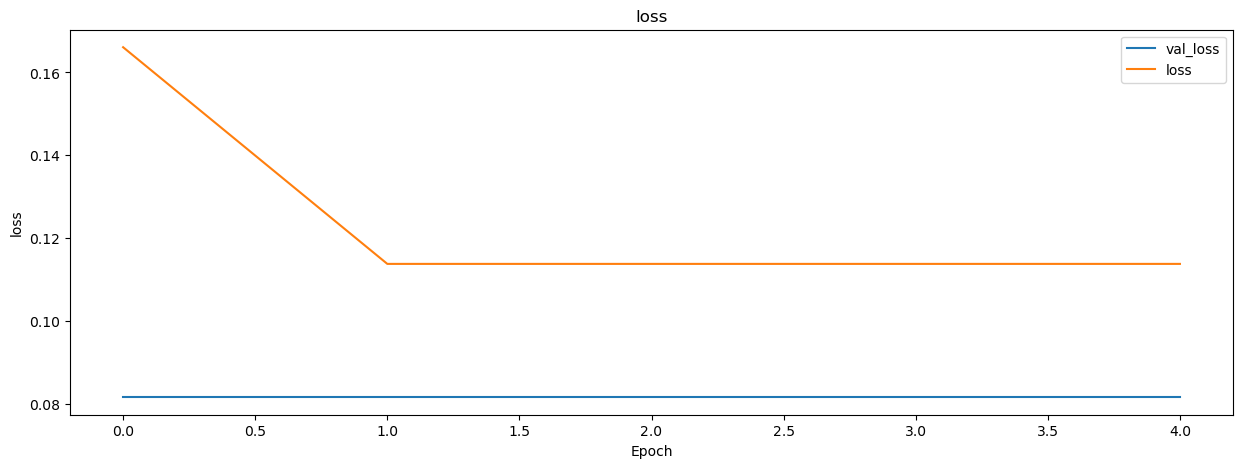

In [21]:
plt.figure(figsize=(15,5))
plt.plot(range(model_history_fine_tuned.epoch[-1]+1),model_history_fine_tuned.history['val_loss'],label='val_loss')
plt.plot(range(model_history_fine_tuned.epoch[-1]+1),model_history_fine_tuned.history['loss'],label='loss')
plt.title('loss'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

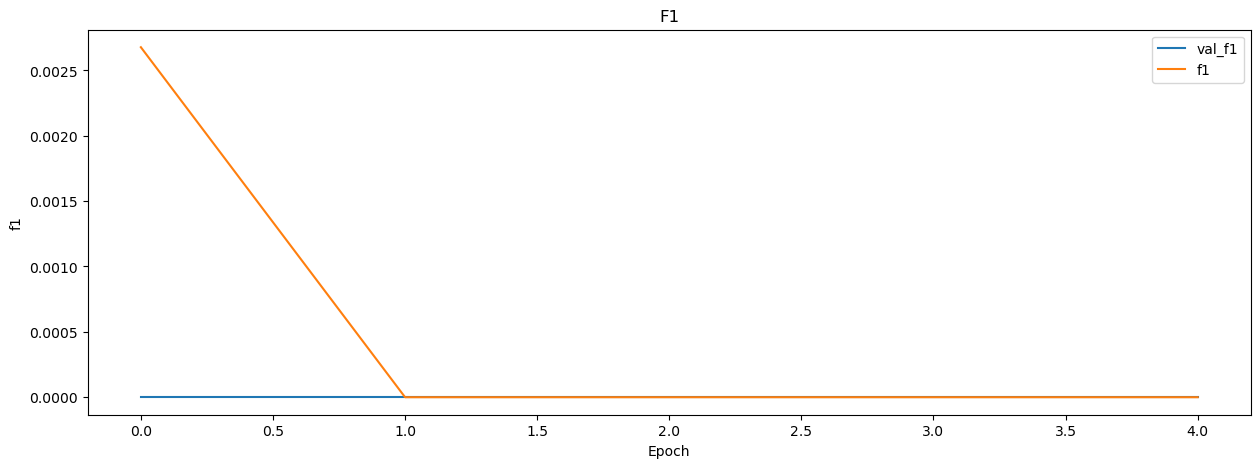

In [22]:
plt.figure(figsize=(15,5))
plt.plot(range(model_history_fine_tuned.epoch[-1]+1),model_history_fine_tuned.history['val_f1'],label='val_f1')
plt.plot(range(model_history_fine_tuned.epoch[-1]+1),model_history_fine_tuned.history['f1'],label='f1')
plt.title('F1'); plt.xlabel('Epoch'); plt.ylabel('f1');plt.legend(); 
plt.show()

In [23]:
# save in the HDF5 format
model_history.save('model.h5', save_format='h5')